In [9]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import os
import psutil
import time
from sklearn.utils import resample
import matplotlib.pyplot as plt
import pandas as pd

Data loading

In [ ]:
file_names = [
    'data/raw/F1_Equal.npy',
    'data/raw/F2_Equal.npy',
    'data/raw/F3_Equal.npy',
    'data/raw/F4_Equal.npy'
]
file_names_fuenffach = [
    'data/raw/F1_Equal.npy',
    'data/raw/F2_Equal.npy',
    'data/raw/F3_Equal.npy',
    'data/raw/F4_Equal.npy',
    'data/raw/F1_Equal.npy',
    'data/raw/F2_Equal.npy',
    'data/raw/F3_Equal.npy',
    'data/raw/F4_Equal.npy',
    'data/raw/F1_Equal.npy',
    'data/raw/F2_Equal.npy',
    'data/raw/F3_Equal.npy',
    'data/raw/F4_Equal.npy',
    'data/raw/F1_Equal.npy',
    'data/raw/F2_Equal.npy',
    'data/raw/F3_Equal.npy',
    'data/raw/F4_Equal.npy',
    'data/raw/F1_Equal.npy',
    'data/raw/F2_Equal.npy',
    'data/raw/F3_Equal.npy',
    'data/raw/F4_Equal.npy'
]



data_parts = [np.load(file, allow_pickle=True) for file in file_names]
combined_data = np.concatenate(data_parts, axis=0)

X = combined_data[:, :-1]
y = combined_data[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

print(f"Trainingsdata: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testdata: X_test: {X_test.shape}, y_test: {y_test.shape}")

Trainingsdaten: X_train: (28185, 17), y_train: (28185,)
Testdaten: X_test: (9395, 17), y_test: (9395,)


Method to get the paths within a tree

In [11]:
def traverse_tree_with_classes(tree, node_id=0, path=None):
    """
    Recursive function that traverses all paths from the root to the leafs in order to return the possible pathes and the class information of each leaf
    """
    if path is None:
        path = []

    # checks if the current node is a leaf
    if tree.children_left[node_id] == -1 and tree.children_right[node_id] == -1:
        class_distribution = tree.value[node_id][0]
        majority_class = class_distribution.argmax()
        return [(path, len(path), majority_class)]

    # contains all paths
    paths = []

    left_child = tree.children_left[node_id]
    if left_child != -1:
        condition = (tree.feature[node_id], "<=", tree.threshold[node_id])
        paths += traverse_tree_with_classes(tree, left_child, path + [condition])

    right_child = tree.children_right[node_id]
    if right_child != -1:
        condition = (tree.feature[node_id], ">", tree.threshold[node_id])
        paths += traverse_tree_with_classes(tree, right_child, path + [condition])

    return paths

Training of the decision tree client models

In [12]:
import time
import os
from sys import getsizeof
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from datetime import datetime

num_trees = 200
average_train_score = 0
average_test_score_tree = 0
lowest_test_score = 1


X_splits = np.array_split(X_train, num_trees)
y_splits = np.array_split(y_train, num_trees)


trees = []
tree_sizes = []
computation_times = []


individual_metrics = []

for i in range(num_trees):
    start_time = time.time()

    tree = DecisionTreeClassifier(
        criterion="entropy",
        splitter="best",
        max_depth=3,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features=None,
        class_weight="balanced",
    )
    tree.fit(X_splits[i], y_splits[i])
    end_time = time.time()

   
    trees.append(tree)

    
    computation_time = end_time - start_time
    computation_times.append(computation_time)

    tree_size = getsizeof(tree)
    tree_sizes.append(tree_size)

    
    test_acc = accuracy_score(y_test, tree.predict(X_test))
    train_acc = accuracy_score(y_splits[i], tree.predict(X_splits[i]))

    average_test_score_tree += test_acc
    average_train_score += train_acc

    if test_acc < lowest_test_score:
        lowest_test_score = test_acc

    
    individual_metrics.append({
        "Tree": i + 1,
        "Size (bytes)": tree_size,
        "Computation Time (seconds)": round(computation_time, 4),
        "Train Accuracy": round(train_acc, 4),
        "Test Accuracy": round(test_acc, 4),
    })


average_tree_size = sum(tree_sizes) / len(tree_sizes)
average_computation_time = sum(computation_times) / len(computation_times)


aktuelles_datum = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


output_file = "tree_metrics_bank.xlsx"


individual_metrics_df = pd.DataFrame(individual_metrics)

Generation of synthetic data

In [ ]:
X_combined_final = []
y_combined_final = []
y_flipped_combined_final =[] #optional


for i in range(num_trees):
    tree = trees[i].tree_

# traverses all trees from the root to the leafs
    paths_with_classes = traverse_tree_with_classes(tree)
    n_samples =100
    n_features = 17
    alpha = 0.1

    first_data = 1

    X_combined_list = []
    y_combined_list = []
    y_flipped_list = [] #optional

    for (path,length, class_of_node) in paths_with_classes:
        #print("Zugriff auf den ersten Pfad der länge", length)
        for i in range(1, length + 1):
            #print(f"    Zugriff auf die letzten {i} Bedingungen:")
            first_run = 1
            for condition in path[-i:]:
                feature, operator, threshold = condition
                #print(f"        Feature {feature} {operator} {threshold}")
                #print("         Klasse", class_of_node)
                feature_index = feature

                if(operator == "<="):
                    #print('         Kleinere Auswertung')
                    split_feature_values = np.random.uniform(
                    threshold - alpha * threshold,  # lower bound
                    threshold,  # upper bound
                    n_samples                     # number of samples
                    )

                if(operator == ">"):
                    #print("         Größere Auswertung")
                    split_feature_values = np.random.uniform(
                    threshold,  # lower bound
                    threshold + alpha * threshold,  # upper bound
                    n_samples                     # number of samples
                    )

                if(first_run == 1):
                    #print("Erster Run deshalb X_syn random initialisiert")
                    X_syn = np.random.choice([-100000, 500000], size=(n_samples, n_features))
                    y_syn = np.where(X_syn[:, feature_index] <= threshold, class_of_node, 1-class_of_node)
                    y_flipped = np.zeros(n_samples) 
                    first_run = 0

                X_syn[:, feature_index] = split_feature_values
                
            if(i < length):
                #print("Entropy hinzugefügt, da Pfad nicht komplett")
                #print(i/length)
                random_flip = np.random.rand(len(y_syn))
                #flip_indices = random_flip > i/length
                if(i == length-1):
                    flip_indices = random_flip < 0.55
                if(i == length-2):
                    flip_indices = random_flip < 0.65
                if(i == length-3):
                    flip_indices = random_flip < 0.85
                y_syn[flip_indices] = 1 - y_syn[flip_indices]
                y_flipped[flip_indices] = 1           
            #print()
            if(first_data == 1):
                X_combined = X_syn
                y_combined = y_syn
                first_data = 0
            #print(X_syn[0])
            #print(y_syn[0])
            X_combined_list.append(X_syn)
            y_combined_list.append(y_syn)
            y_flipped_list.append(y_flipped) 


    X_combined = np.vstack(X_combined_list)
    print("X_combined",X_combined.shape)
    y_combined = np.hstack(y_combined_list)
    y_flipped_combined = np.hstack(y_flipped_list) 
    print(y_combined.shape)
    print(y_flipped_combined.shape) 
    X_combined_final.append(X_combined)
    y_combined_final.append(y_combined)
    y_flipped_combined_final.append(y_flipped_combined) 


X_combined_final = np.vstack(X_combined_final)
y_combined_final = np.hstack(y_combined_final)
y_flipped_combined_final = np.hstack(y_flipped_combined_final) 
print(y_combined_final.shape)
print(y_flipped_combined_final.shape) 

Majority vote for the class of the synthetic data

In [14]:
from scipy.stats import mode
predictions = np.array([tree.predict(X_combined_final) for tree in trees])  


y_combined_final, _ = mode(predictions, axis=0)
y_combined_final.shape

(367400,)

Addition of entropy in order to get more stable results

In [15]:
unique_values, counts = np.unique(y_flipped_combined_final, return_counts=True)
print("Häufigkeiten in flipped:", counts)

unique_values, counts = np.unique(y_combined_final, return_counts=True)
print("Häufigkeiten in y:", counts)
y_flipped_combined_final = y_flipped_combined_final.astype(int)
y_combined_final = y_combined_final.astype(int)

y_combined_final = y_flipped_combined_final ^ y_combined_final

unique_values, counts = np.unique(y_combined_final, return_counts=True)
print("Häufigkeiten in y nach flip:", counts)

Häufigkeiten in flipped: [226695 140705]
Häufigkeiten in y: [ 98612 268788]
Häufigkeiten in y nach flip: [165257 202143]


Training of the global Decision tree model

Accuracy auf Trainingsdaten: 0.63
Accuracy auf Testdaten: 0.89


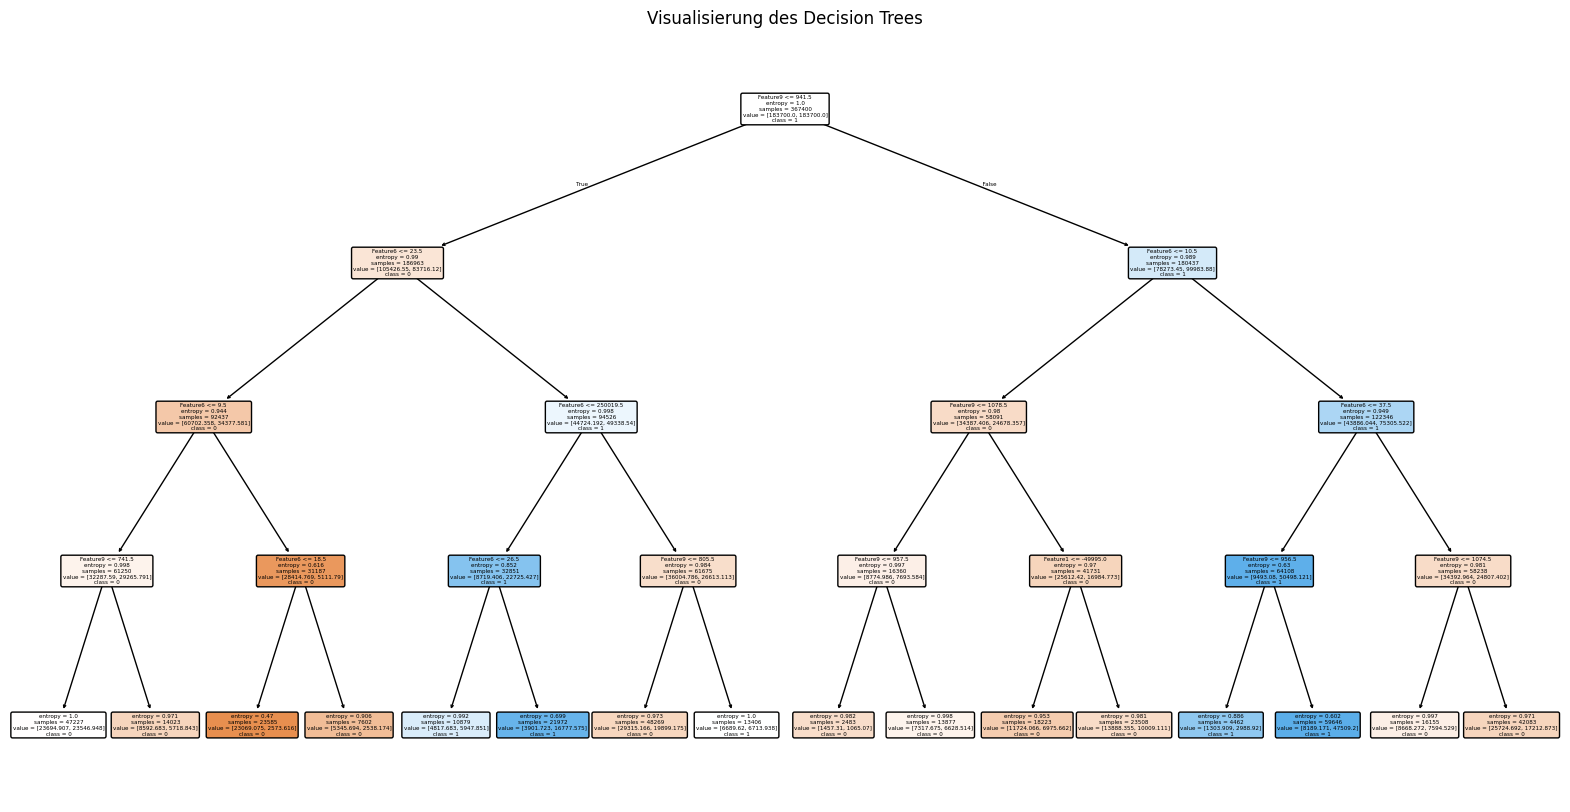

exists
Metrics saved to tree_metrics_bank.xlsx


c:\Users\thilo\Desktop\Federated_Learning\Federated-Learning\.venv\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [16]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf_syn = DecisionTreeClassifier(
    criterion="entropy",
    splitter="best",
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features=None, 
    class_weight="balanced",
    #random_state=42
)


clf_syn.fit(X_combined_final, y_combined_final)

y_syn_train_pred = clf_syn.predict(X_combined_final)
y_syn_test_pred = clf_syn.predict(X_test)


train_accuracy_syn = accuracy_score(y_combined_final, y_syn_train_pred)
average_test_score_tree_main = accuracy_score(y_test, y_syn_test_pred)

print(f"Accuracy auf Trainingsdaten: {train_accuracy_syn:.2f}")
print(f"Accuracy auf Testdaten: {average_test_score_tree_main:.2f}")

feature_names = [
    "Feature1", "Feature2", "Feature3", "Feature4",
    "Feature5", "Feature6", "Feature7", "Feature8",
    "Feature9", "Feature10", "Feature11", "Feature12",
    "Feature13", "Feature14", "Feature15", "Feature16"
]

plt.figure(figsize=(20, 10))
plot_tree(clf_syn, feature_names=feature_names, class_names=list(map(str, clf_syn.classes_)), filled=True, rounded=True)
plt.title("Visualisierung des Decision Trees")
plt.show()

summary_data = {
    "Metric": [
        "Number of Trees",
        "Train Score on synthetic data",
        "Final Test Score",
        "Average Tree Size (bytes)",
        "Average Computation Time (seconds)",
    ],
    "Value": [
        num_trees,
        round(train_accuracy_syn, 4),
        round(average_test_score_tree_main, 4),
        round(average_tree_size, 4),
        round(average_computation_time, 4),
    ],
}
summary_df = pd.DataFrame(summary_data).set_index("Metric").transpose()

# writes results in a csv file
if os.path.exists(output_file):
    
    print("exists")
    with pd.ExcelWriter(output_file, engine="openpyxl", mode="a", if_sheet_exists="new") as writer:
        summary_df.to_excel(writer, sheet_name=f"{aktuelles_datum}_Summary", index=False)
        individual_metrics_df.to_excel(writer, sheet_name=f"{aktuelles_datum}_Individual Metrics", index=False)
else:
    
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        summary_df.to_excel(writer, sheet_name=f"{aktuelles_datum}_Summary", index=False)
        individual_metrics_df.to_excel(writer, sheet_name=f"{aktuelles_datum}_Individual Metrics", index=False)

print(f"Metrics saved to {output_file}")

Implementation of the Fed-AVG algorithm

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
from sys import getsizeof
from sklearn.metrics import accuracy_score
from datetime import datetime
import pandas as pd
import os

# Neural Network Definition
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(SimpleNN, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_sizes[0])
        self.hidden2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.output = nn.Linear(hidden_sizes[1], output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.output(x)
        return x

# Federated Averaging
def federated_averaging(models):
    global_model = models[0]
    global_dict = global_model.state_dict()

    for key in global_dict.keys():
        global_dict[key] = torch.mean(torch.stack([model.state_dict()[key].float() for model in models]), dim=0)

    global_model.load_state_dict(global_dict)
    return global_model

# Evaluation Function
def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.tensor(X, dtype=torch.float32))
        predictions = torch.argmax(outputs, dim=1).numpy()
        accuracy = accuracy_score(y, predictions)
    return accuracy
print(average_test_score_tree_main)
# Data and Parameters
num_clients = len(X_splits)
input_size = X_splits[0].shape[1]
hidden_sizes = [12, 12]
output_size = len(np.unique(y_train))  # Number of classes
epochs = 10
rounds = 130
batch_size = 32
learning_rate = 0.01
stop_threshold = average_test_score_tree_main  # Stop if test accuracy reaches this value

avg_acc_client = 0
avg_acc_client_test = 0
# Initialize Models for Each Client
client_models = [SimpleNN(input_size, hidden_sizes, output_size) for _ in range(num_clients)]
client_optimizers = [optim.Adam(model.parameters(), lr=learning_rate) for model in client_models]

# Global Model
global_model = SimpleNN(input_size, hidden_sizes, output_size)

# Metrics Storage
total_computation_time = 0
round_computation_times = []
weight_sizes = []
client_computation_times = []
client_weight_sizes = []
epoch_times = []
average_train_accuracies = []
average_test_accuracies = []

# Federated Learning Rounds
for round_idx in range(rounds):
    print(f"Round {round_idx + 1}/{rounds}")

    # Distribute Global Model to Clients
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

    # Training
    round_start_time = time.time()
    round_client_times = []
    round_client_weights = []

    for epoch in range(epochs):
        epoch_start_time = time.time()
        # Train each client
        for client_idx, (model, optimizer, X_client, y_client) in enumerate(zip(client_models, client_optimizers, X_splits, y_splits)):
            epoch_start_time = time.time()

            model.train()
            optimizer.zero_grad()

            X_client_tensor = torch.tensor(X_client, dtype=torch.float32)
            y_client_tensor = torch.tensor(y_client, dtype=torch.long)

            outputs = model(X_client_tensor)
            loss = nn.CrossEntropyLoss()(outputs, y_client_tensor)
            loss.backward()
            optimizer.step()

            # Measure computation time
            epoch_time = time.time() - epoch_start_time
            epoch_times.append(epoch_time)
            total_computation_time += epoch_time
            
            round_client_times.append(epoch_time)

            # Evaluate local model
            acc_client = evaluate_model(model, X_client, y_client)
            avg_acc_client += acc_client

            acc_test = evaluate_model(model, X_test, y_test)
            avg_acc_client_test += acc_test

            # Measure client weight size
            client_weight_size = sum(getsizeof(param) for param in model.state_dict().values())
            round_client_weights.append(client_weight_size)

    

    # Round Metrics
    round_time = time.time() - round_start_time
    round_computation_times.append(round_time)
    #total_computation_time += round_time

    # Federated Averaging
    global_model = federated_averaging(client_models)

    # Measure global weight size
    global_weights_size = sum(getsizeof(param) for param in global_model.state_dict().values())
    weight_sizes.append(global_weights_size)

    # Store client metrics for this round
    client_computation_times.append(round_client_times)
    client_weight_sizes.append(round_client_weights)

    # Calculate and store average accuracies
    avg_train_accuracy = (avg_acc_client / num_clients) / epochs
    avg_test_accuracy = (avg_acc_client_test / num_clients) / epochs
    average_train_accuracies.append(avg_train_accuracy)
    average_test_accuracies.append(avg_test_accuracy)

    # Evaluate Global Model
    global_accuracy = evaluate_model(global_model, X_test, y_test)
    print(f"  Global Model on Test Data: Accuracy = {global_accuracy:.2f}")
    print(f"  Average Client Accuracy on Training Data: {avg_train_accuracy:.2f}")
    print(f"  Average Client Accuracy on Test Data: {avg_test_accuracy:.2f}")
    print(f"treshold: {stop_threshold}")
    print("")

    # Reset average values
    avg_acc_client = 0
    avg_acc_client_test = 0

    # Stop training if test accuracy threshold is met
    if global_accuracy >= stop_threshold:
        print(f"Stopping training as global test accuracy reached {avg_test_accuracy:.2f} (>= {stop_threshold}).")
        break

# Final Evaluation
print("Final Global Model Evaluation")
final_accuracy = evaluate_model(global_model, np.vstack(X_splits), np.concatenate(y_splits))
print(f"Final Global Model Accuracy on Training Data = {final_accuracy:.2f}")
final_accuracy = evaluate_model(global_model, X_test, y_test)
print(f"Final Global Model Accuracy on Test Data = {final_accuracy:.2f}")

# Print Metrics
average_computation_time = total_computation_time / ((round_idx + 1) * 200)
average_weight_size = sum(weight_sizes) / len(weight_sizes)
average_epoch_time = sum(epoch_times) / len(epoch_times)

print(f"Average Computation Time per Round: {average_computation_time:.4f} seconds")
print(f"Average Weight Size: {average_weight_size:.2f} bytes")
print(f"Average Time per Epoch: {average_epoch_time:.4f} seconds")

# Aktuelles Datum und Uhrzeit
aktuelles_datum = datetime.now()
aktuelles_datum = aktuelles_datum.strftime("%Y-%m-%d_%H-%M-%S")
print("Aktuelles Datum und Uhrzeit:", aktuelles_datum)

# writes results in a csv file
output_file = "nn_metrics_federated.xlsx"


summary_data = {
    "Metric": [
        "Number of Rounds",
        "Total Computation Time (seconds)",
        "Average Computation Time per Round (seconds)",
        "Average Weight Size (bytes)",
        "Average Time per Epoch (seconds)",
        "Final Test Accuracy"
    ],
    "Value": [
        round_idx + 1,
        total_computation_time,
        average_computation_time,
        average_weight_size,
        average_epoch_time,
        final_accuracy,
    ],
}
summary_df = pd.DataFrame(summary_data).set_index("Metric").transpose()


round_data = {
    "Round": list(range(1, round_idx + 2)),
    "Round Computation Time (seconds)": round_computation_times,
    "Global Weight Size (bytes)": weight_sizes,
}
round_df = pd.DataFrame(round_data)


if os.path.exists(output_file):
    
    with pd.ExcelWriter(output_file, engine="openpyxl", mode="a", if_sheet_exists="new") as writer:
        summary_df.to_excel(writer, sheet_name=f"{aktuelles_datum}_Summary", index=False)
        round_df.to_excel(writer, sheet_name=f"{aktuelles_datum}_Rounds", index=False)
else:
    
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        summary_df.to_excel(writer, sheet_name=f"{aktuelles_datum}_Summary", index=False)
        round_df.to_excel(writer, sheet_name=f"{aktuelles_datum}_Rounds", index=False)

print(f"Metrics saved to {output_file}")

0.8854709952102182
Round 1/130
  Global Model on Test Data: Accuracy = 0.74
  Average Client Accuracy on Training Data: 0.63
  Average Client Accuracy on Test Data: 0.62
treshold: 0.8854709952102182

Round 2/130
  Global Model on Test Data: Accuracy = 0.74
  Average Client Accuracy on Training Data: 0.65
  Average Client Accuracy on Test Data: 0.63
treshold: 0.8854709952102182

Round 3/130
  Global Model on Test Data: Accuracy = 0.75
  Average Client Accuracy on Training Data: 0.65
  Average Client Accuracy on Test Data: 0.64
treshold: 0.8854709952102182

Round 4/130
  Global Model on Test Data: Accuracy = 0.75
  Average Client Accuracy on Training Data: 0.66
  Average Client Accuracy on Test Data: 0.65
treshold: 0.8854709952102182

Round 5/130
  Global Model on Test Data: Accuracy = 0.75
  Average Client Accuracy on Training Data: 0.67
  Average Client Accuracy on Test Data: 0.65
treshold: 0.8854709952102182

Round 6/130
  Global Model on Test Data: Accuracy = 0.75
  Average Client Ac